In [8]:
import pandas as pd
import numpy as np
import nltk
from transformers import pipeline
import torch
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import tensorflow as tf

In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ANIL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
df = pd.read_csv(r"C:\Users\ANIL\Downloads\test(in).csv")
print("Dataset Shape:", df.shape)
print("Columns:", df.columns)
print(df.head())

Dataset Shape: (2191, 4)
Columns: Index(['Subject', 'body', 'date', 'from'], dtype='object')
                                        Subject  \
0                          EnronOptions Update!   
1                                  (No Subject)   
2  Phone Screen  Interview - Shannon L. Burnham   
3                         RE: My new work email   
4                                           Bet   

                                                body       date  \
0  EnronOptions Announcement\n\n\nWe have updated...  5/10/2010   
1  Marc,\n\nUnfortunately, today is not going to ...  7/29/2010   
2  When: Wednesday, June 06, 2001 10:00 AM-11:00 ...  7/25/2011   
3  we were thinking papasitos (we can meet somewh...  3/25/2010   
4  Since you never gave me the $20 for the last t...  5/21/2011   

                      from  
0     sally.beck@enron.com  
1      eric.bass@enron.com  
2     sally.beck@enron.com  
3  johnny.palmer@enron.com  
4  lydia.delgado@enron.com  


### Task 1: Sentiment Labeling

#Initialize sentiment analysis pipeline

In [11]:
sentiment_analyzer = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

In [12]:
def label_sentiment(text):
    if pd.isna(text):
        return 'Neutral'  # Handle missing text
    result = sentiment_analyzer(text, truncation=True, max_length=512)[0]
    score = result['score']
    label = result['label']
    # Convert to Positive/Negative/Neutral
    if label == 'POSITIVE' and score > 0.6:
        return 'Positive'
    elif label == 'NEGATIVE' and score > 0.6:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment labeling

In [13]:
df['sentiment'] = df['body'].apply(label_sentiment)
print("Sentiment Distribution:\n", df['sentiment'].value_counts())

Sentiment Distribution:
 sentiment
Negative    1165
Positive     975
Neutral       51
Name: count, dtype: int64


# Save augmented dataset

In [14]:
df.to_csv(r'C:\Users\ANIL\Downloads\test_labeled.csv', index=False)
print("Augmented dataset saved as 'test_labeled.csv'")

Augmented dataset saved as 'test_labeled.csv'


## Task 2: Exploratory Data Analysis (EDA)

In [15]:
df.info()
print("\nMissing Values:\n", df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Subject    2191 non-null   object
 1   body       2191 non-null   object
 2   date       2191 non-null   object
 3   from       2191 non-null   object
 4   sentiment  2191 non-null   object
dtypes: object(5)
memory usage: 85.7+ KB

Missing Values:
 Subject      0
body         0
date         0
from         0
sentiment    0
dtype: int64


#Convert date to datetime

In [16]:
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y', errors='coerce')
print("Date Range:", df['date'].min(), "to", df['date'].max())

Date Range: 2010-01-01 00:00:00 to 2011-12-31 00:00:00


In [19]:
#Create visualization folder
if not os.path.exists('visualizations'):
    os.makedirs('visualizations')

# Visualization 1: Sentiment Distribution

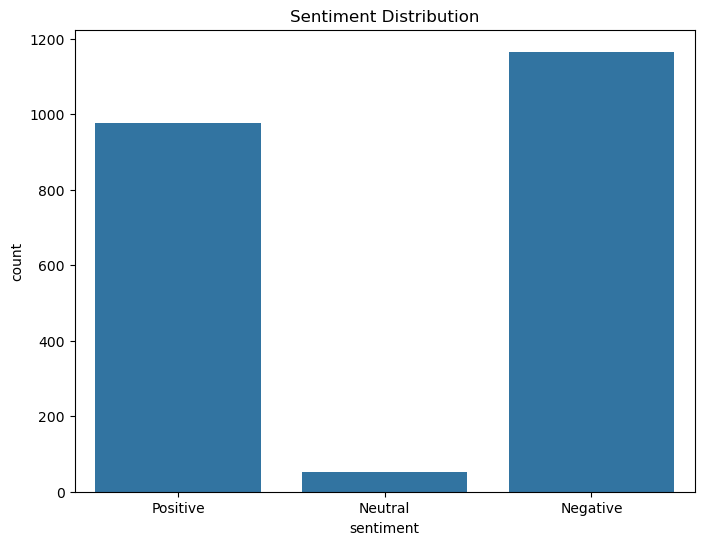

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution')
plt.savefig('visualizations/sentiment_distribution.png')
plt.show()

Visualization 2: Messages per Sender

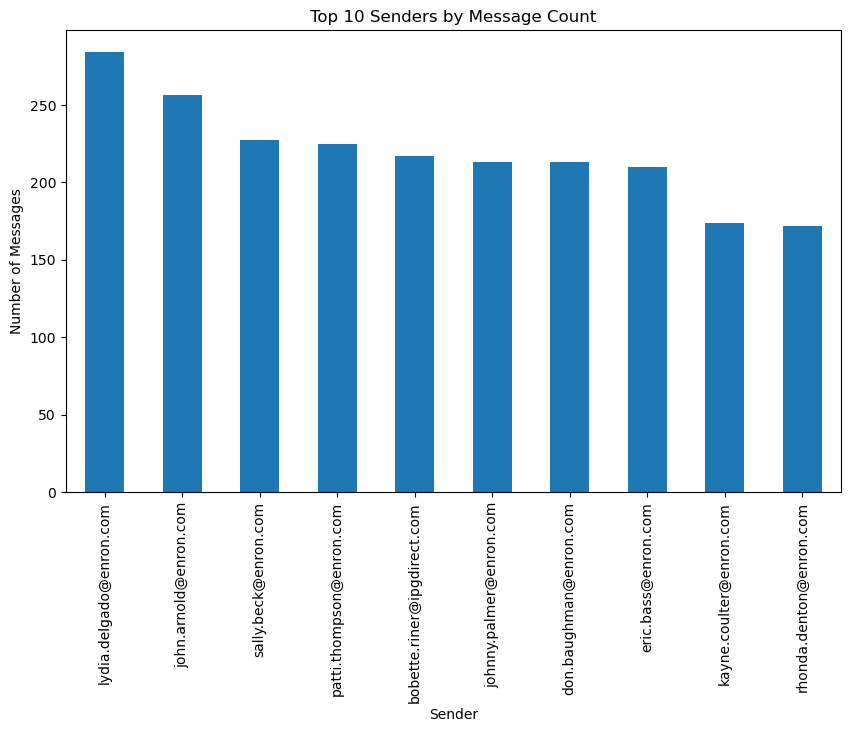

In [22]:
sender_counts = df['from'].value_counts()
plt.figure(figsize=(10, 6))
sender_counts[:10].plot(kind='bar')
plt.title('Top 10 Senders by Message Count')
plt.xlabel('Sender')
plt.ylabel('Number of Messages')
plt.savefig('visualizations/top_senders.png')
plt.show()

# Visualization 3:Sentiment Over Time

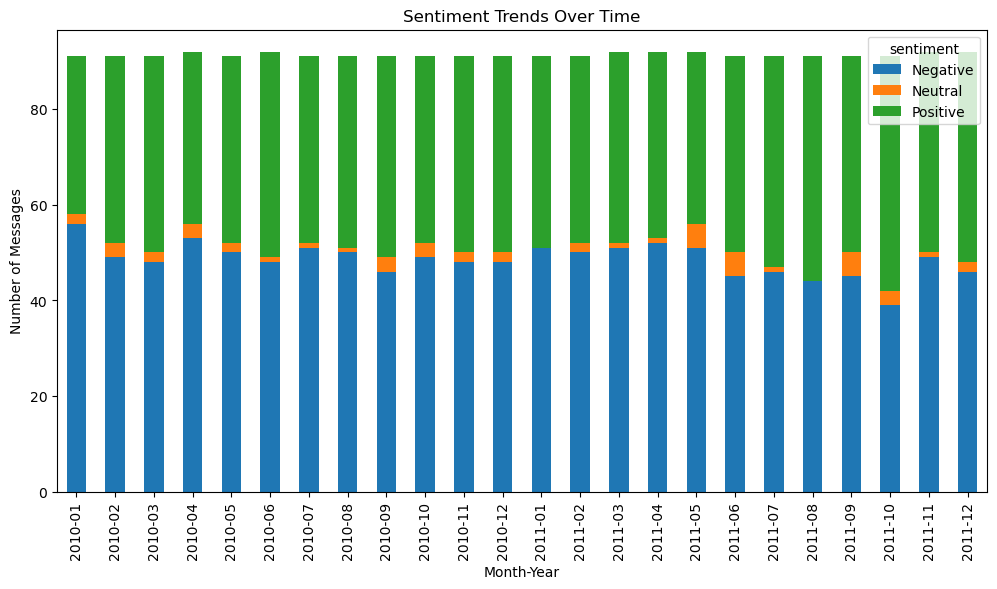

In [23]:
df['month_year'] = df['date'].dt.to_period('M')
sentiment_over_time = df.groupby(['month_year', 'sentiment']).size().unstack(fill_value=0)
sentiment_over_time.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Sentiment Trends Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Messages')
plt.savefig('visualizations/sentiment_trends.png')
plt.show()

## Task 3: Employee Score Calculation

In [24]:
def sentiment_score(sentiment):
    if sentiment == 'Positive':
        return 1
    elif sentiment == 'Negative':
        return -1
    else:
        return 0

Apply scoring

In [25]:
df['score'] = df['sentiment'].apply(sentiment_score)

Group by employee and month

In [27]:
df['month_year'] = df['date'].dt.to_period('M')
employee_scores = df.groupby(['from', 'month_year'])['score'].sum().reset_index()
print("Sample Employee Scores:\n", employee_scores.head())

Sample Employee Scores:
                           from month_year  score
0  bobette.riner@ipgdirect.com    2010-01     -2
1  bobette.riner@ipgdirect.com    2010-02     -3
2  bobette.riner@ipgdirect.com    2010-03     -3
3  bobette.riner@ipgdirect.com    2010-04     -2
4  bobette.riner@ipgdirect.com    2010-05      2


Save scores

In [29]:
employee_scores.to_csv(r'C:\Users\ANIL\Downloads\employee_scores.csv', index=False)
print("Employee scores saved as 'employee_scores.csv'")

Employee scores saved as 'employee_scores.csv'


## Task 4: Employee Ranking

# Function to get top 3 positive and negative employees

In [30]:
def rank_employees(monthly_scores):
    rankings = []
    for month in monthly_scores['month_year'].unique():
        month_data = monthly_scores[monthly_scores['month_year'] == month]
        
        # Top 3 Positive
        top_positive = month_data.nlargest(3, 'score')[['from', 'score']]
        top_positive['rank_type'] = 'Top Positive'
        top_positive['month_year'] = month
        
        # Top 3 Negative
        top_negative = month_data.nsmallest(3, 'score')[['from', 'score']]
        top_negative['rank_type'] = 'Top Negative'
        top_negative['month_year'] = month
        
        rankings.append(pd.concat([top_positive, top_negative]))
    
    return pd.concat(rankings).sort_values(['month_year', 'score', 'from'], ascending=[True, False, True])

Get rankings

In [31]:
rankings = rank_employees(employee_scores)
print("Sample Rankings:\n", rankings.head(10))

Sample Rankings:
                             from  score     rank_type month_year
72         john.arnold@enron.com      3  Top Positive    2010-01
96       johnny.palmer@enron.com      0  Top Positive    2010-01
192      rhonda.denton@enron.com     -1  Top Positive    2010-01
48           eric.bass@enron.com     -4  Top Negative    2010-01
120      kayne.coulter@enron.com     -5  Top Negative    2010-01
216         sally.beck@enron.com     -5  Top Negative    2010-01
25        don.baughman@enron.com      4  Top Positive    2010-02
97       johnny.palmer@enron.com      1  Top Positive    2010-02
145      lydia.delgado@enron.com      1  Top Positive    2010-02
1    bobette.riner@ipgdirect.com     -3  Top Negative    2010-02


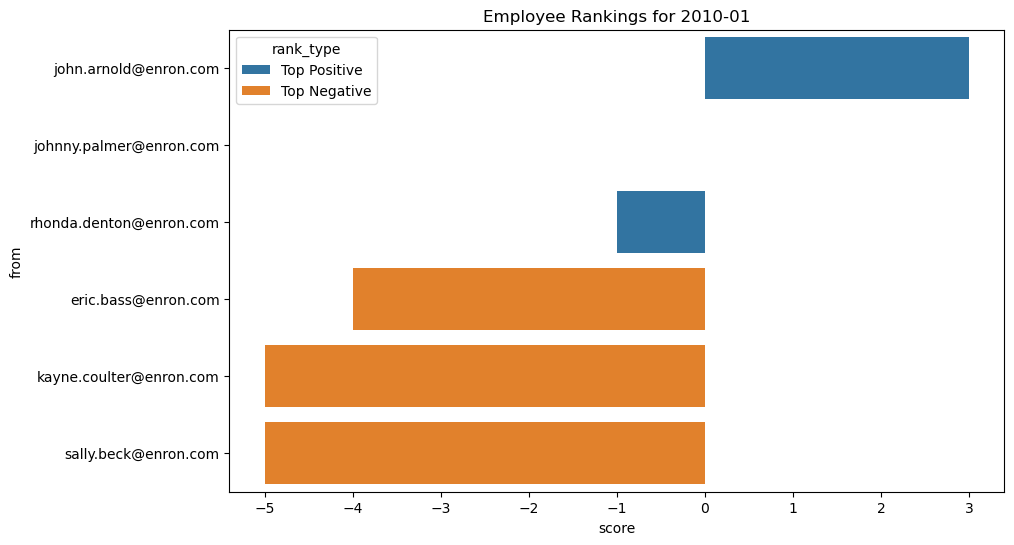

In [32]:
# Visualization: Rankings for a Sample Month
sample_month = rankings['month_year'].unique()[0]
month_ranking = rankings[rankings['month_year'] == sample_month]
plt.figure(figsize=(10, 6))
sns.barplot(x='score', y='from', hue='rank_type', data=month_ranking)
plt.title(f'Employee Rankings for {sample_month}')
plt.savefig('visualizations/sample_month_ranking.png')
plt.show()

In [33]:
# Save rankings
rankings.to_csv(r'C:\Users\ANIL\Downloads\employee_rankings.csv', index=False)
print("Rankings saved as 'employee_rankings.csv'")

Rankings saved as 'employee_rankings.csv'


## Task 5: Flight Risk Identification

In [34]:
# Function to identify flight risks
def identify_flight_risks(df):
    flight_risks = []
    negative_msgs = df[df['sentiment'] == 'Negative'][['from', 'date']]
    
    for employee in negative_msgs['from'].unique():
        emp_msgs = negative_msgs[negative_msgs['from'] == employee].sort_values('date')
        for i in range(len(emp_msgs)):
            start_date = emp_msgs.iloc[i]['date']
            end_date = start_date + timedelta(days=30)
            count = len(emp_msgs[(emp_msgs['date'] >= start_date) & (emp_msgs['date'] <= end_date)])
            if count >= 4:
                flight_risks.append({'employee': employee, 'start_date': start_date, 'negative_count': count})
    
    return pd.DataFrame(flight_risks)

In [35]:
# Identify flight risks
flight_risks = identify_flight_risks(df)
print("Flight Risks:\n", flight_risks)

Flight Risks:
                     employee start_date  negative_count
0       sally.beck@enron.com 2010-01-10               7
1       sally.beck@enron.com 2010-01-15               6
2       sally.beck@enron.com 2010-01-16               6
3       sally.beck@enron.com 2010-01-16               6
4       sally.beck@enron.com 2010-01-20               4
..                       ...        ...             ...
946  lydia.delgado@enron.com 2011-12-02               8
947  lydia.delgado@enron.com 2011-12-04               7
948  lydia.delgado@enron.com 2011-12-08               6
949  lydia.delgado@enron.com 2011-12-11               5
950  lydia.delgado@enron.com 2011-12-17               4

[951 rows x 3 columns]


In [36]:
# Save flight risks
flight_risks.to_csv(r'C:\Users\ANIL\Downloads\flight_risks.csv', index=False)
print("Flight risks saved as 'flight_risks.csv'")

Flight risks saved as 'flight_risks.csv'


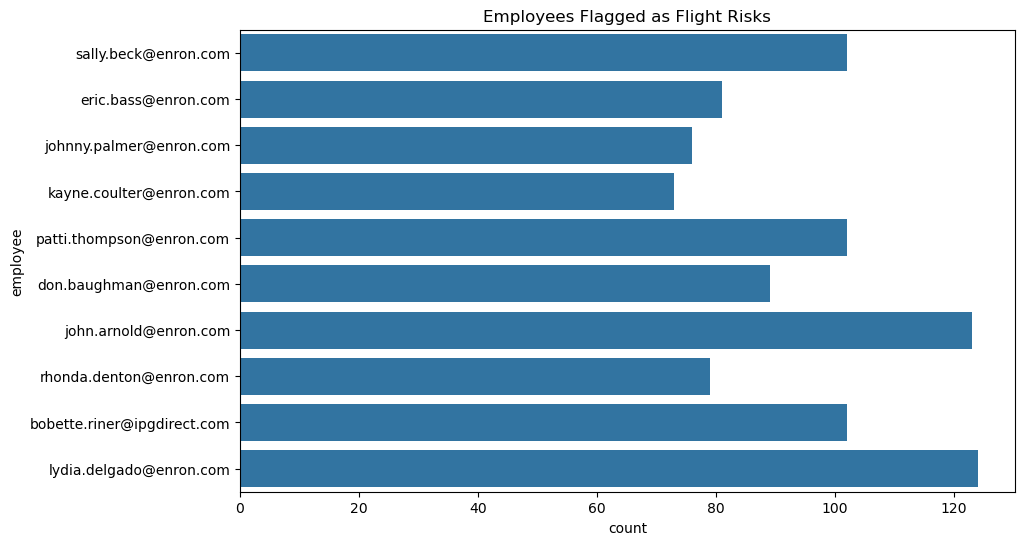

In [37]:
# Visualization: Flight Risk Counts
if not flight_risks.empty:
    plt.figure(figsize=(10, 6))
    sns.countplot(y='employee', data=flight_risks)
    plt.title('Employees Flagged as Flight Risks')
    plt.savefig('visualizations/flight_risks.png')
    plt.show()
else:
    print("No flight risks identified.")

## Task 6: Predictive Modeling

In [38]:
# Prepare features
df['message_count'] = df.groupby(['from', 'month_year'])['body'].transform('count')
df['positive_ratio'] = df.groupby(['from', 'month_year'])['sentiment'].transform(lambda x: (x == 'Positive').mean())
df['negative_ratio'] = df.groupby(['from', 'month_year'])['sentiment'].transform(lambda x: (x == 'Negative').mean())
df['days_since_start'] = (df['date'] - df['date'].min()).dt.days

In [39]:
# Aggregate features
features_df = df.groupby(['from', 'month_year']).agg({
    'score': 'sum',
    'message_count': 'mean',
    'positive_ratio': 'mean',
    'negative_ratio': 'mean',
    'days_since_start': 'mean'
}).reset_index()

In [41]:
# Split data
X = features_df[['message_count', 'positive_ratio', 'negative_ratio', 'days_since_start']]
y = features_df['score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [42]:
# Train model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [43]:
# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 3.88
R² Score: 0.49


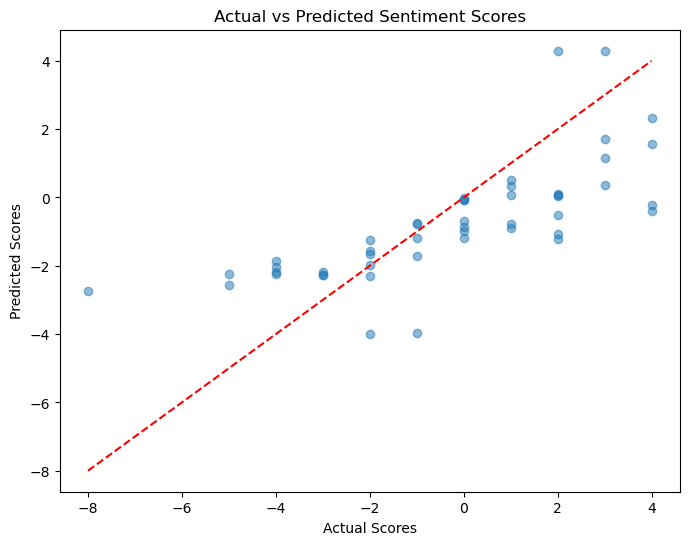

In [44]:
# Visualize predictions
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Scores')
plt.ylabel('Predicted Scores')
plt.title('Actual vs Predicted Sentiment Scores')
plt.savefig('visualizations/prediction_performance.png')
plt.show()